<a href="https://colab.research.google.com/github/dcordovacarrizales/xrayanalysis/blob/master/Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


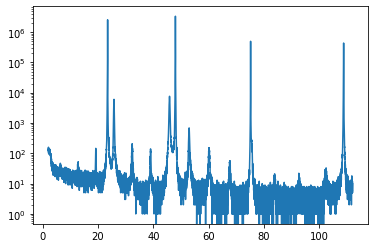

In [6]:
import matplotlib.pyplot as plt

# BeautifulSoup XML Parser
# API: https://www.crummy.com/software/BeautifulSoup/bs4/doc/
from bs4 import BeautifulSoup

from google.colab import drive
drive.mount('/content/drive')
infile = '/content/drive/My Drive/Mundy Group/Three Muskateers Group/Code/test.xrdml'

# converts xrdml file into BeautifulSoup object
def convertToBS(filename):
  with open(filename,'r') as file:
    file_input = file.read()
  return BeautifulSoup(file_input)

# get 2Theta start and end positions
def get2Theta(filename):
  soup = convertToBS(filename)
  return [float(soup.startposition.string),float(soup.endposition.string)]

# get intensities of tth scan 
def getIntensities(filename):
  soup = convertToBS(filename)
  return [float(intensity) for intensity in soup.intensities.string.split()]

# get id 
def getID(filename):
  soup = convertToBS(filename)
  return soup.id.string

# create dictionary of 2Theta and intensity values
def createDict(filename):
  d = {}
  [tth_beg,tth_end] = get2Theta(filename)
  intensities = getIntensities(filename)
  tth = tth_beg
  incr = (tth_end - tth_beg) / (len(intensities) - 1)
  for i in intensities:
    d[tth] = i
    tth = tth + incr
  return d


#TODO: Data Analysis
# Resolve Peaks (Maxima)



#TODO: Data Output
# Semilogy Graph
tth = createDict(infile)
x,y = list(tth.keys()),list(tth.values())
plt.semilogy(x,y)
